In [ ]:
import numpy as np
import h5py
import os
import glob
import random
import umap
import umap.plot
import matplotlib.pyplot as plt
import matplotlib as mpl

## Indices
Only load subsequences not being "gap subsequences", subsequences entirely made up Ns, or flagged subsequences. Therefore the those indices will be excluded beforehand and saved to disk.

In [2]:
def save_valid_coords(h5_file):
    h5df = h5py.File(h5_file, "r")
    blacklist = True if "blacklist" in h5df["data"].keys() else False  # bool
    coords = []
    n = 1000
    for j in range(0, h5df["data/X"].shape[0], n):
        X = np.array(h5df["data/X"][j:j + n])
        indices = np.where(np.max(X[:, :, 0], axis=1) != 0.25)[0]
        if blacklist:
            mask = np.array(h5df["data/blacklist"][j:j + n], dtype=bool)
            indices = indices[mask[indices]] + j  # only mask existing indices
        else:
            indices = indices + j
        coords.append(indices)
        
    coords = np.concatenate(coords)
    file_stem = os.path.basename(h5_file).split('.')[0]
    np.save(f"h5_files/{file_stem}_umap_valid_coords.npy", coords)

In [ ]:
h5_files = glob.glob(os.path.join("h5_files", "*.h5"))
for h5 in h5_files:
    save_valid_coords(h5)

## Data loading
Set a seed, so you can load the same random data, if need be.

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

In [3]:
chipseq_species = ["Creinhardtii", "Enindensis", "Bdistachyon", "Zmays", "Sitalica", "Obrachyantha", "Sindicum",
                   "Slycopersicum", "Gmax", "Pbretschneideri", "Ppersica", "Mdomestica", "Boleracea", "Brapa",
                   "Bnapus", "Mpolymorpha", "Achinensis"]
atacseq_species = ["Bnatans", "Mpolymorpha", "Enindensis", "Othomaeum", "Bdistachyon", "Zmays", "Slycopersicum",
                   "Gmax", "Mdomestica", "Bnapus", "Achinensis", "Pmiliaceum", "Sbicolor"]

In [4]:
# all training species
species = ["Bnatans", "Creinhardtii", "Mpolymorpha", "Enindensis", "Othomaeum", "Bdistachyon", "Zmays",
           "Sitalica", "Obrachyantha", "Sindicum", "Slycopersicum", "Gmax", "Pbretschneideri",
           "Ppersica", "Mdomestica", "Boleracea", "Brapa", "Bnapus", "Achinensis", "Pmiliaceum", "Sbicolor"]

In [5]:
def extract_peaks(bed_file):
    """Create a dictionary out of called peaks."""
    ids = np.loadtxt(bed_file, delimiter="\t", dtype=str, skiprows=1, usecols=0)
    starts = np.loadtxt(bed_file, delimiter="\t", dtype=int, skiprows=1, usecols=1)
    ends = np.loadtxt(bed_file, delimiter="\t", dtype=int, skiprows=1, usecols=2)
    peaks = dict.fromkeys(ids)
    for id_ in peaks:
        peaks[id_] = np.stack([starts[np.where(id_ == ids)[0]], ends[np.where(id_ == ids)[0]]]).T
    return peaks

In [6]:
def count_peaks(peak_dict, id_, start_ends):
    if id_ not in peak_dict.keys():
        return 0
    a = (peak_dict[id_] > start_ends[0]) & (peak_dict[id_] < start_ends[1])
    return np.count_nonzero(np.any(a, axis=1))  # count peaks with overlap

In [7]:
set_seed(9885)
atac_labels = []
chip_labels = []
X_atac = []
X_chip = []
peak_path = "experimental_merged_peaks"
atac_fileend = "_atacseq_merged_peaks.narrowPeak"
chip_fileend = "_h3k4me3_merged_peaks.broadPeak"
for spec in species:
    # X
    h5df = h5py.File(f"h5_files/{spec}.h5", "r")
    indices = np.load(f"h5_files/{spec}_umap_valid_coords.npy")
    # load 5 % of each X
    chosen_idxs = np.sort(np.random.choice(indices, size=(round(indices.shape[0] * 0.05),), replace=False))
    x = np.array(h5df["data/X"][chosen_idxs], dtype=np.float16)
    seqids = np.array(h5df["data/seqids"][chosen_idxs])
    start_ends = np.array(h5df["data/start_ends"][chosen_idxs])
    print(spec, x.shape)
    
    # append data
    if spec in atacseq_species and spec in chipseq_species:
        X_atac.append(x)
        X_chip.append(x)
        atac_peaks = extract_peaks(f"{peak_path}/{spec}{atac_fileend}")
        chip_peaks = extract_peaks(f"{peak_path}/{spec}{chip_fileend}")
        
        for i in range(seqids.shape[0]):
            atac_labels.append(count_peaks(atac_peaks, seqids[i].decode(), start_ends[i]))
            chip_labels.append(count_peaks(chip_peaks, seqids[i].decode(), start_ends[i]))
        
    elif spec in atacseq_species and spec not in chipseq_species:
        X_atac.append(x)
        atac_peaks = extract_peaks(f"{peak_path}/{spec}{atac_fileend}")
        
        for i in range(seqids.shape[0]):
            atac_labels.append(count_peaks(atac_peaks, seqids[i].decode(), start_ends[i]))
        
    elif spec not in atacseq_species and spec in chipseq_species:
        X_chip.append(x)
        chip_peaks = extract_peaks(f"{peak_path}/{spec}{chip_fileend}")
        
        for i in range(seqids.shape[0]):
            chip_labels.append(count_peaks(chip_peaks, seqids[i].decode(), start_ends[i]))
            
X_atac = np.concatenate(X_atac)
X_chip = np.concatenate(X_chip)
atac_labels = np.array(atac_labels)
chip_labels = np.array(chip_labels)

Bnatans (670, 21384, 4)
Creinhardtii (506, 21384, 4)
Mpolymorpha (1274, 21384, 4)
Enindensis (4833, 21384, 4)
Othomaeum (1171, 21384, 4)
Bdistachyon (1267, 21384, 4)
Zmays (9968, 21384, 4)
Sitalica (1876, 21384, 4)
Obrachyantha (1211, 21384, 4)
Sindicum (1092, 21384, 4)
Slycopersicum (3568, 21384, 4)
Gmax (4448, 21384, 4)
Pbretschneideri (2404, 21384, 4)
Ppersica (1055, 21384, 4)
Mdomestica (3042, 21384, 4)
Boleracea (2450, 21384, 4)
Brapa (1598, 21384, 4)
Bnapus (3818, 21384, 4)
Achinensis (3145, 21384, 4)
Pmiliaceum (4038, 21384, 4)
Sbicolor (3260, 21384, 4)


In [8]:
X_atac = X_atac.reshape(X_atac.shape[0], X_atac.shape[1]*X_atac.shape[2])
X_chip = X_chip.reshape(X_chip.shape[0], X_chip.shape[1]*X_chip.shape[2])

In [9]:
print(X_atac.shape, atac_labels.shape, X_chip.shape, chip_labels.shape)

(44502, 85536) (44502,) (47555, 85536) (47555,)


## Compute and plot the Umap

In [4]:
def plot_the_umap(emb, labels, figsize=(14, 8), dpi=75, fsize=13):
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    sc = ax.scatter(emb[:, 0], emb[:, 1], c=labels, s=3, vmin=0, vmax=np.max(labels), cmap="turbo")
    
    for l in ax.get_yticklabels():
        l.set_family("Times New Roman")

    for l in ax.get_xticklabels():
        l.set_family("Times New Roman")
        
    ax.tick_params(axis="x", labelsize=fsize-1)
    ax.tick_params(axis="y", labelsize=fsize-1)
    
    ax.set_ylabel("UMAP 1", size=fsize, fontname="Times New Roman")
    ax.set_xlabel("UMAP 2", size=fsize, fontname="Times New Roman")

    cbar = plt.colorbar(sc)
    cbar.ax.set_ylabel("Number of peaks (with overlap)",rotation=-90, va="bottom", size=fsize+1, fontname="Times New Roman")
    cbar.ax.tick_params(labelsize=fsize-2, color="black", direction="out", length=5., pad=0.5, width=1.5)
    for l in cbar.ax.yaxis.get_ticklabels():
        l.set_family("Times New Roman")
    plt.show()

In [10]:
# ATAC-seq data
red = umap.UMAP(n_neighbors=10, n_components=2, min_dist=0.1)
emb = red.fit_transform(X_atac)

In [11]:
# save for later usage
np.save("atac_embeddings.npy", emb)
np.save("atacseq_labels.npy", atac_labels)

In [12]:
# ChIP-seq data
red = umap.UMAP(n_neighbors=10, n_components=2, min_dist=0.1)
emb2 = red.fit_transform(X_chip)

In [13]:
# save for later usage
np.save("chip_embeddings.npy", emb2)
np.save("chipseq_labels.npy", chip_labels)

In [2]:
# load ATAC-seq
emb = np.load("umap/atac_embeddings.npy")
atac_labels = np.load("umap/atacseq_labels.npy")

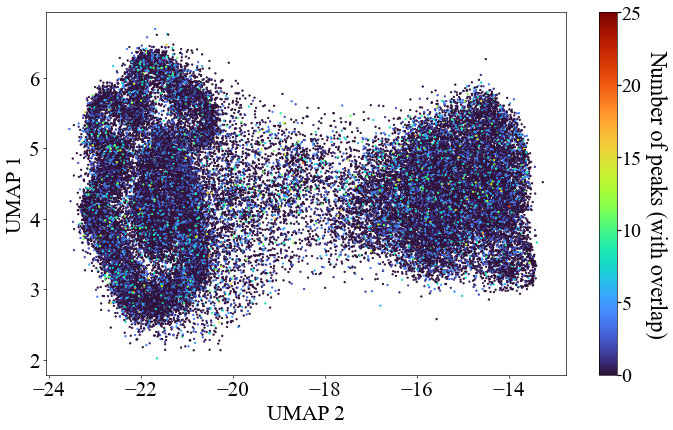

In [5]:
plot_the_umap(emb, atac_labels, dpi=60, fsize=26)

In [6]:
# load ChIP-seq
emb2 = np.load("umap/chip_embeddings.npy")
chip_labels = np.load("umap/chipseq_labels.npy")

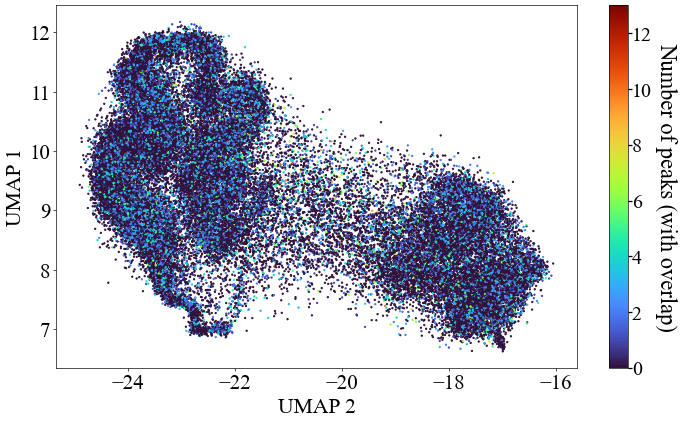

In [7]:
plot_the_umap(emb2, chip_labels, dpi=60, fsize=26)